In [1]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

zones = gpd.read_file("austin_zones.geojson", )
zones = zones.loc[zones['geometry'].is_valid, :]

<AxesSubplot:>

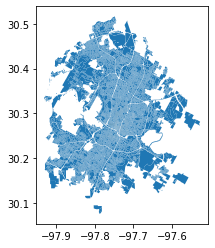

In [2]:
zones.plot()

<AxesSubplot:>

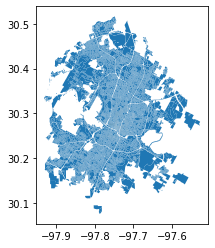

In [3]:
exploded_zones = zones.explode()
exploded_zones.rename(columns={"zoning_id": "tile_ID"}, inplace=True)
exploded_zones.plot()

In [4]:
import pandas as pd
import skmob

all_trajectories = pd.read_csv("sampled_from_raw_5000_per_day.csv")
trajectory_df = skmob.TrajDataFrame(all_trajectories, latitude="lat", longitude="long", datetime="time", user_id="id", timestamp=True)
trajectory_df.crs = exploded_zones.crs

zone_labeled_trajectories = trajectory_df.mapping(exploded_zones, remove_na=True)
print(zone_labeled_trajectories.head())

   Unnamed: 0                               uid            datetime  \
0           0  267Q5PN47P649RO7452QNQ332932R838 2020-03-02 11:27:22   
1           1  QQ84SQ0593S79296O2PQ7O846RQ478Q1 2020-03-02 11:51:44   
2           2  982N6P45O48R94N6O286PS874N18574Q 2020-03-02 22:06:35   
3           3  S404556PQ17P98RO49Q189N5387S47S3 2020-03-02 01:34:35   
4           4  60QP02OQQRP1981049ON61N96SP9977R 2020-03-02 04:55:00   

         lat        lng tile_ID  
0  30.198294 -97.788665  121046  
1  30.227056 -97.785481  119720  
2  30.319252 -97.716938  124820  
3  30.223679 -97.762774  235083  
4  30.355502 -97.737934  202412  


In [5]:
id_relevance_dict = {}
for _, x in zone_labeled_trajectories.iterrows():
    if x["tile_ID"] not in id_relevance_dict.keys():
        id_relevance_dict[x["tile_ID"]] = 0
    id_relevance_dict[x["tile_ID"]] += 1
    
new_col = []
for _, x in exploded_zones.iterrows():
    if x["tile_ID"] in id_relevance_dict.keys():
        new_col.append(id_relevance_dict[x["tile_ID"]] + 1)
    else:
        new_col.append(1)
        
exploded_zones["relevance"] = new_col
print(exploded_zones.head())

    created_by        shape_area               created_date zoning_ztype  \
0 0       None     17632.5390625  2006-01-01T00:00:00+00:00          CBD   
1 0    Parkerr  176218.357421875  2011-06-14T00:00:00+00:00         I-RR   
2 0       None    42494.74609375  2006-01-01T00:00:00+00:00         SF-5   
3 0       None   76272.626953125  2006-01-01T00:00:00+00:00           LO   
4 0       None   45483.462890625  2006-01-01T00:00:00+00:00           GR   

    objectid      shape_length modified_by              modified_date tile_ID  \
0 0     2651  531.442604452751      meekss  2019-08-06T14:39:58+00:00  121576   
1 0    17343  1690.92313476536      MeeksS  2012-11-07T12:09:02+00:00  237218   
2 0    13094     893.622695467      meekss  2019-08-06T14:41:14+00:00  136432   
3 0     3543   1174.8060484927      meekss  2019-08-06T14:40:18+00:00  123872   
4 0     9872  1163.18555888787      meekss  2019-08-06T14:40:09+00:00  122363   

                                              geometry  

<AxesSubplot:>

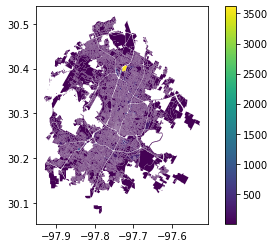

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
exploded_zones.plot(column='relevance', ax=ax, legend=True)

In [10]:
from skmob.models.epr import Ditras
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import filtering, compression, detection, clustering

select_trajectories = pd.read_csv("200.csv")
tdf = skmob.TrajDataFrame(select_trajectories, latitude="lat", longitude="long", datetime="time", user_id="id", timestamp=True)
tdf.crs = exploded_zones.crs
tdf = tdf.mapping(exploded_zones, remove_na=True)
ctdf = compression.compress(tdf)
stdf = detection.stops(ctdf)
cstdf = clustering.cluster(stdf)

# instantiate and train the MarkovDiaryGenerator
mdg = MarkovDiaryGenerator()
mdg.fit(cstdf, 10, lid='cluster')

# set start time, end time and tessellation for the simulation
start_time = pd.to_datetime('2020/10/29 09:00:00')
end_time = pd.to_datetime('2020/11/29 09:00:00')
# download tessellation data from https://github.com/scikit-mobility/tutorials/blob/master/mda_masterbd2020/data/NY_counties_2011.geojson
tessellation = exploded_zones

# instantiate the model
ditras = Ditras(mdg)

# run the model
ditras_tdf = ditras.generate(start_time, end_time, tessellation, relevance_column='relevance', n_agents=3, od_matrix=None, show_progress=True)
print(ditras_tdf)

100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

     uid            datetime        lat        lng
0      1 2020-10-29 09:00:00  30.397687 -97.749654
1      1 2020-10-30 07:00:00  30.388122 -97.741032
2      1 2020-10-30 08:00:00  30.397687 -97.749654
3      1 2020-10-30 19:00:00  30.388122 -97.741032
4      1 2020-10-30 21:00:00  30.397687 -97.749654
..   ...                 ...        ...        ...
203    3 2020-11-26 23:00:00  30.256757 -97.730583
204    3 2020-11-27 01:00:00  30.231665 -97.722757
205    3 2020-11-27 03:00:00  30.256757 -97.730583
206    3 2020-11-28 03:00:00  30.231665 -97.722757
207    3 2020-11-28 04:00:00  30.256757 -97.730583

[208 rows x 4 columns]


In [8]:
plot = tdf.plot_trajectory(max_users=3)
plot

/home/thomaswei/miniconda2/envs/skmob/lib/python3.7/site-packages/scikit_mobility-1.0-py3.7.egg/skmob/utils/plot.py:164: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/home/thomaswei/miniconda2/envs/skmob/lib/python3.7/site-packages/scikit_mobility-1.0-py3.7.egg/skmob/utils/plot.py:173: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [11]:
plot = ditras_tdf.plot_trajectory()
plot

/home/thomaswei/miniconda2/envs/skmob/lib/python3.7/site-packages/scikit_mobility-1.0-py3.7.egg/skmob/utils/plot.py:164: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/home/thomaswei/miniconda2/envs/skmob/lib/python3.7/site-packages/scikit_mobility-1.0-py3.7.egg/skmob/utils/plot.py:173: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
